# Extending SeqIKPy for mouse forelimb kinematics
 
## What this example does:
- Models a single arm with 4 effective DOFs (shoulder yaw, shoulder pitch, shoulder roll, elbow pitch).
- Runs two sequential IK stages: first recover shoulder yaw & pitch using the elbow trajectory, then recover shoulder roll & elbow pitch using the wrist trajectory while holding yaw/pitch fixed.
- Plots joint angles and compares reconstructed forward kinematics with original marker data.

In [1]:
from dataclasses import dataclass
from typing import Optional, Dict, Tuple
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

from ikpy.chain import Chain
from ikpy.link import OriginLink, URDFLink

from seqikpy.leg_inverse_kinematics import LegInvKinBase
from seqikpy.visualization import plot_3d_points, animate_3d_points

# Simple axes helpers
X_AXIS = [1.0, 0.0, 0.0]
Y_AXIS = [0.0, 1.0, 0.0]
Z_AXIS = [0.0, 0.0, 1.0]

plt.style.use('dark_background')

## Mouse arm helper dataclass and the sequential IK solver

Below we include the `MouseArmSegmentLengths` dataclass and the `MouseArmIKSeq` class. The first stores segment lengths for the mouse arm model, while the second implements the sequential IK solver for the mouse arm.

```{note}
Note that instead of creating a template for the body model, we obtain the morphological data from the kinematics itself.
```

### Stage 1: 
Calculate shoulder yaw & pitch using elbow trajectory.

### Stage 2:
Calculate shoulder roll and elbow pitch DOFs using wrist trajectory while shoulder yaw/pitch values are set from Stage 1.

In [2]:

@dataclass
class MouseArmSegmentLengths:
    upper_arm: float  # shoulder -> elbow
    forearm: float  # elbow -> wrist


class MouseArmIKSeq(LegInvKinBase):
    """
    Sequential inverse kinematics for a single mouse arm.

    Stages:
    - Stage 1: shoulder yaw + pitch (2 DOF), using the elbow as end-effector.
    - Stage 2: shoulder roll + elbow pitch (2 DOF), using the wrist as end-effector
               while keeping yaw & pitch fixed from Stage 1.
    """

    def __init__(
        self,
        arm_markers: np.ndarray,
        segment_lengths: Optional[MouseArmSegmentLengths] = None,
    ) -> None:
        if (
            arm_markers.ndim != 3
            or arm_markers.shape[2] != 3
        ):
            raise ValueError(
                "arm_markers must have shape (n_frames, 3, 3): "
                "[shoulder, elbow, wrist] x [x,y,z]"
            )

        self.arm_markers = arm_markers
        self.n_frames = arm_markers.shape[0]

        if segment_lengths is None:
            self.segment_lengths = self._estimate_segment_lengths(arm_markers)
        else:
            self.segment_lengths = segment_lengths

        self.joint_angles_dict: Dict[str, np.ndarray] = {}
        self.forward_kinematics: Dict[str, np.ndarray] = {}

    @staticmethod
    def _estimate_segment_lengths(arm_markers: np.ndarray) -> MouseArmSegmentLengths:
        """Estimate segment lengths (upper arm, forearm) as median distances."""
        shoulder = arm_markers[:, 0, :]
        elbow = arm_markers[:, 1, :]
        wrist = arm_markers[:, 2, :]

        upper_arm_lengths = np.linalg.norm(elbow - shoulder, axis=1)
        forearm_lengths = np.linalg.norm(wrist - elbow, axis=1)

        upper_arm = np.median(upper_arm_lengths)
        forearm = np.median(forearm_lengths)

        return MouseArmSegmentLengths(
            upper_arm=float(upper_arm),
            forearm=float(forearm),
        )

    @staticmethod
    def _compute_fk_positions(chain: Chain, joint_angles: np.ndarray) -> np.ndarray:
        """Compute forward kinematics positions for all links."""
        fk = chain.forward_kinematics(joint_angles, full_kinematics=True)
        positions = np.zeros((len(chain.links), 3))
        for i, T in enumerate(fk):
            positions[i, :] = T[:3, 3]
        return positions

    def calculate_ik_stage(
        self,
        end_effector_pos: np.ndarray,
        origin: np.ndarray,
        initial_angles: np.ndarray,
        segment_name: str,
        **kwargs,
    ) -> np.ndarray:
        """Calculate a single sequential IK stage for the mouse arm."""
        stage = kwargs.get("stage", 1)
        hide_progress_bar = kwargs.get("hide_progress_bar", False)

        if stage not in (1, 2):
            raise ValueError("MouseArmIKSeq supports only stage=1 or stage=2")

        frames_no = end_effector_pos.shape[0]
        end_effector_pos_diff = end_effector_pos - origin

        if origin.size == 3:
            origin = np.tile(origin, (frames_no, 1))

        if stage == 1:
            # Stage 1: shoulder yaw & pitch from elbow trajectory
            chain1 = self._create_chain_stage1()
            n_links1 = len(chain1.links)
            joint_angles = np.zeros((frames_no, n_links1))

            init = (
                np.zeros(n_links1)
                if initial_angles is None
                else np.asarray(initial_angles)
            )
            for t in trange(
                frames_no, disable=hide_progress_bar, desc=f"{segment_name} stage 1"
            ):
                init = joint_angles[t - 1] if t > 0 else init
                sol = chain1.inverse_kinematics(
                    target_position=end_effector_pos_diff[t],
                    initial_position=init,
                )
                joint_angles[t] = sol

            shoulder_yaw = joint_angles[:, 1]
            shoulder_pitch = joint_angles[:, 2]

            elbow_recon = np.zeros((frames_no, 3))
            for t in range(frames_no):
                pos_links = self._compute_fk_positions(chain1, joint_angles[t])
                elbow_recon[t] = pos_links[3] + origin[t]

            self.joint_angles_dict[f"Angle_{segment_name}_Shoulder_yaw"] = shoulder_yaw
            self.joint_angles_dict[
                f"Angle_{segment_name}_Shoulder_pitch"
            ] = shoulder_pitch

            wrist_placeholder = np.zeros_like(elbow_recon)
            forward_kin = np.stack([origin, elbow_recon, wrist_placeholder], axis=1)
            return forward_kin

        # stage == 2: shoulder roll & elbow pitch from wrist trajectory
        yaw_key = f"Angle_{segment_name}_Shoulder_yaw"
        pitch_key = f"Angle_{segment_name}_Shoulder_pitch"
        if (
            yaw_key not in self.joint_angles_dict
            or pitch_key not in self.joint_angles_dict
        ):
            raise RuntimeError(
                "Stage 2 requires stage 1 results (yaw/pitch) to be available"
            )

        shoulder_yaw = self.joint_angles_dict[yaw_key]
        shoulder_pitch = self.joint_angles_dict[pitch_key]

        chain2_dof = 6
        joint_angles2 = np.zeros((frames_no, chain2_dof))

        init2 = (
            np.zeros(chain2_dof)
            if initial_angles is None
            else np.asarray(initial_angles)
        )
        elbow_recon_stage2 = np.zeros((frames_no, 3))
        wrist_recon = np.zeros((frames_no, 3))

        for t in trange(
            frames_no, disable=hide_progress_bar, desc=f"{segment_name} stage 2"
        ):
            chain2 = self._create_chain_stage2(
                yaw=shoulder_yaw[t], pitch=shoulder_pitch[t]
            )
            init2 = joint_angles2[t - 1] if t > 0 else init2
            sol = chain2.inverse_kinematics(
                target_position=end_effector_pos_diff[t], initial_position=init2
            )
            joint_angles2[t] = sol

            pos_links = self._compute_fk_positions(chain2, joint_angles2[t])
            elbow_recon_stage2[t] = pos_links[4] + origin[t]
            wrist_recon[t] = pos_links[5] + origin[t]

        shoulder_roll = joint_angles2[:, 3]
        elbow_pitch = joint_angles2[:, 4]

        self.joint_angles_dict[f"Angle_{segment_name}_Shoulder_roll"] = shoulder_roll
        self.joint_angles_dict[f"Angle_{segment_name}_Elbow_pitch"] = elbow_pitch

        forward_kin = np.stack([origin, elbow_recon_stage2, wrist_recon], axis=1)
        return forward_kin

    def _create_chain_stage1(self) -> Chain:
        """Stage 1 chain: shoulder yaw/pitch, elbow dummy."""
        L_upper = self.segment_lengths.upper_arm

        links = [
            OriginLink(),
            URDFLink(
                name="L_Shoulder_yaw",
                origin_translation=[0.0, 0.0, 0.0],
                origin_orientation=[0.0, 0.0, 0.0],
                rotation=X_AXIS,
                joint_type="revolute",
                bounds=[-np.pi, np.pi],
            ),
            URDFLink(
                name="L_Shoulder_pitch",
                origin_translation=[0.0, 0.0, 0.0],
                origin_orientation=[0.0, 0.0, 0.0],
                rotation=Y_AXIS,
                joint_type="revolute",
                bounds=[-np.pi / 2, np.pi / 2],
            ),
            URDFLink(
                name="L_Elbow_dummy",
                origin_translation=[0.0, 0.0, -L_upper],
                origin_orientation=[0.0, 0.0, 0.0],
                rotation=None,
                joint_type="fixed",
            ),
        ]
        return Chain(name="mouse_arm_stage_1", links=links)

    def _create_chain_stage2(self, yaw: float, pitch: float) -> Chain:
        """Stage 2 chain: fixed yaw/pitch, shoulder roll, elbow pitch, wrist dummy."""
        L_upper = self.segment_lengths.upper_arm
        L_fore = self.segment_lengths.forearm

        links = [
            OriginLink(),
            URDFLink(
                name="L_Shoulder_yaw",
                origin_translation=[0.0, 0.0, 0.0],
                origin_orientation=[yaw, 0.0, 0.0],
                rotation=None,
                joint_type="fixed",
            ),
            URDFLink(
                name="L_Shoulder_pitch",
                origin_translation=[0.0, 0.0, 0.0],
                origin_orientation=[0.0, pitch, 0.0],
                rotation=None,
                joint_type="fixed",
            ),
            URDFLink(
                name="L_Shoulder_roll",
                origin_translation=[0.0, 0.0, 0.0],
                origin_orientation=[0.0, 0.0, 0.0],
                rotation=Z_AXIS,
                joint_type="revolute",
                bounds=[-np.pi / 2, np.pi / 2],
            ),
            URDFLink(
                name="L_Elbow_pitch",
                origin_translation=[0.0, 0.0, -L_upper],
                origin_orientation=[0.0, 0.0, 0.0],
                rotation=Y_AXIS,
                joint_type="revolute",
                bounds=[-np.pi, 0.0],
            ),
            URDFLink(
                name="L_Wrist_dummy",
                origin_translation=[0.0, 0.0, -L_fore],
                origin_orientation=[0.0, 0.0, 0.0],
                rotation=None,
                joint_type="fixed",
            ),
        ]
        return Chain(name="L_mouse_arm_stage_2", links=links)

    def run_ik_and_fk(
        self,
        hide_progress_bar: bool = False,
        initial_angles1: Optional[np.ndarray] = None,
        initial_angles2: Optional[np.ndarray] = None,
    ) -> Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray]]:
        """
        Run both stages of IK and compute forward kinematics.
        """
        shoulder = self.arm_markers[:, 0, :]
        elbow = self.arm_markers[:, 1, :]
        wrist = self.arm_markers[:, 2, :]

        fk_stage1 = self.calculate_ik_stage(
            end_effector_pos=elbow,
            origin=shoulder,
            initial_angles=initial_angles1,
            segment_name="L_arm",
            stage=1,
            hide_progress_bar=hide_progress_bar,
        )

        fk_stage2 = self.calculate_ik_stage(
            end_effector_pos=wrist,
            origin=shoulder,
            initial_angles=initial_angles2,
            segment_name="L_arm",
            stage=2,
            hide_progress_bar=hide_progress_bar,
        )

        self.joint_angles = {
            "L_Shoulder_yaw": self.joint_angles_dict.get("Angle_L_arm_Shoulder_yaw"),
            "L_Shoulder_pitch": self.joint_angles_dict.get(
                "Angle_L_arm_Shoulder_pitch"
            ),
            "L_Shoulder_roll": self.joint_angles_dict.get("Angle_L_arm_Shoulder_roll"),
            "L_Elbow_pitch": self.joint_angles_dict.get("Angle_L_arm_Elbow_pitch"),
        }

        self.forward_kinematics = {
            "L_shoulder": shoulder.copy(),
            "L_elbow_stage1": fk_stage1[:, 1, :],
            "L_elbow": fk_stage2[:, 1, :],
            "L_wrist": fk_stage2[:, 2, :],
        }

        return self.joint_angles, self.forward_kinematics

## Running the solver with the Gilmer 2024 dataset

We now demonstrate how to use the `MouseArmIKSeq` class with the `gilmer2024_mouse_reaching` dataset. If you have your own 3D marker data, you can adapt the code below by replacing the data loading section with your own data.

The dataset are downloaded from: https://simtk.org/projects/mouse_arm2024

In [3]:
# Path used in the example script (adjust if you placed the data elsewhere)
data_path = Path('../data/gilmer2024_mouse_reaching') / 'mouse_forelimb_coords_gilmer2024_reachset2.pkl'

reaching_kin = pd.read_pickle(data_path)
n_frames = len(reaching_kin['L_shoulder_x'])
joints = ('shoulder', 'elbow', 'wrist')
kin_array = np.zeros((n_frames, 3, 3))
for i, joint in enumerate(joints):
    kin_array[:, i, 0] = reaching_kin[f'L_{joint}_x']
    kin_array[:, i, 1] = reaching_kin[f'L_{joint}_y']
    kin_array[:, i, 2] = reaching_kin[f'L_{joint}_z']


print('Frames:', n_frames)
print('kin_array shape:', kin_array.shape)

Frames: 50
kin_array shape: (50, 3, 3)


## Run sequential IK and visualize results

We instantiate `MouseArmIKSeq`, run both stages, then plot joint angles and compare FK reconstructions against the original markers. Adjust `initial_angles1`/`initial_angles2` if needed.


In [4]:
# Instantiate solver and run IK
ik_solver = MouseArmIKSeq(arm_markers=kin_array)
joint_angles, fk = ik_solver.run_ik_and_fk(
    hide_progress_bar=False,
    initial_angles1=[0, 0, 0, 0],
    initial_angles2=[0, 0, 0, 0, -0.2, 0],
)

print('Available joint angle keys:', list(joint_angles.keys()))

L_arm stage 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.93it/s]

Available joint angle keys: ['L_Shoulder_yaw', 'L_Shoulder_pitch', 'L_Shoulder_roll', 'L_Elbow_pitch']


## Plot joint angles

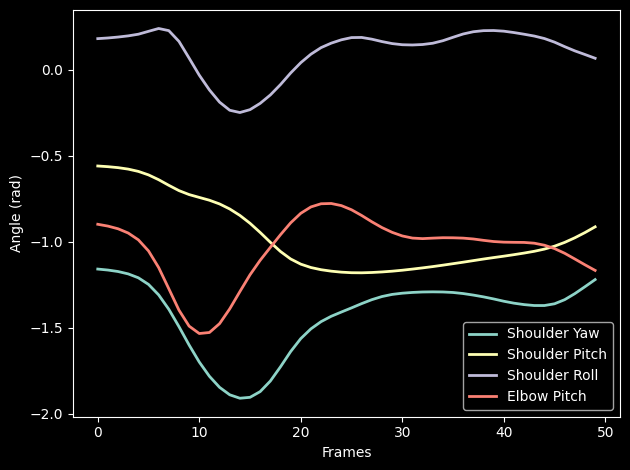

In [5]:
# Plot joint angles

plt.figure()
for key, label in [
    ("L_Shoulder_yaw", "Shoulder Yaw"),
    ("L_Shoulder_pitch", "Shoulder Pitch"),
    ("L_Shoulder_roll", "Shoulder Roll"),
    ("L_Elbow_pitch", "Elbow Pitch"),
]:
    plt.plot(joint_angles[key], label=label, lw=2)

plt.xlabel("Frames")
plt.ylabel("Angle (rad)")
plt.legend()
plt.tight_layout()
plt.show()

## Plot reconstructed vs original markers in 3D

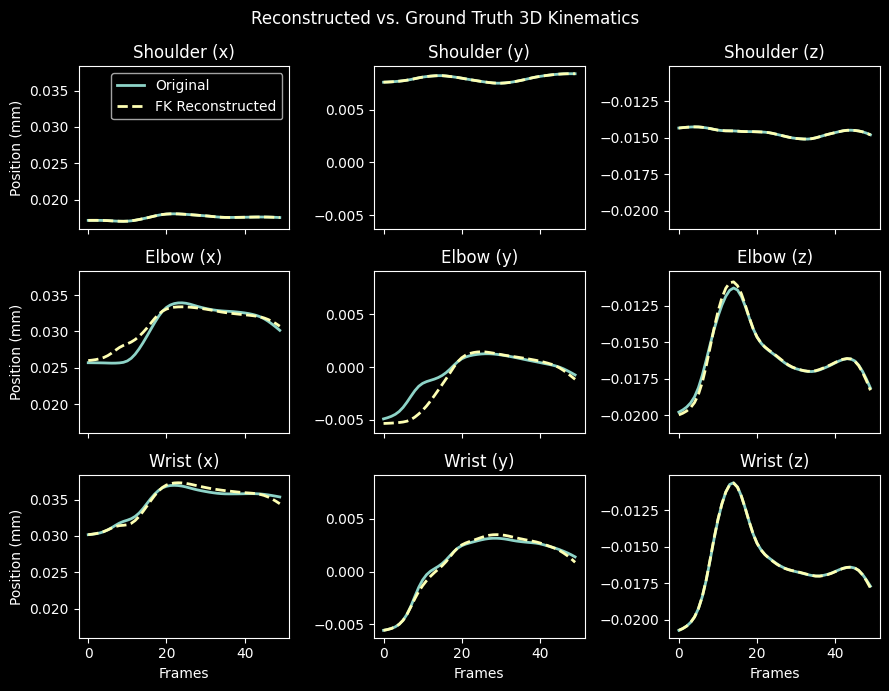

In [6]:
fig, ax_arr = plt.subplots(3, 3, figsize=(9, 7), sharex=True, sharey="col")
coords = ("x", "y", "z")
for i, joint in enumerate(joints):
    for j, coord in enumerate(coords):
        ax = ax_arr[i, j]
        ax.plot(
            kin_array[:, i, j],
            label="Original",
            ls="-", lw=2,
        )
        ax.plot(
            fk[f"L_{joint}"][:, j],
            label="FK Reconstructed",
            ls="--", lw=2,
        )
        ax.set_title(f"{joint.capitalize()} ({coord})")
        if i == 0 and j == 0:
            ax.legend()

        if j == 0:
            ax.set_ylabel("Position (mm)")

        if i == 2:
            ax.set_xlabel("Frames")

plt.suptitle("Reconstructed vs. Ground Truth 3D Kinematics")
plt.tight_layout()
plt.show()

## Alternatively, you can visualize or animate the data using SeqIKPy's built-in visualization tools.

 2025-12-12 18:21:46,956 - INFO- Making animation...
 2025-12-12 18:21:49,022 - INFO- Animation is saved at mouse_fk_ik_elev_0_azim_0.mp4


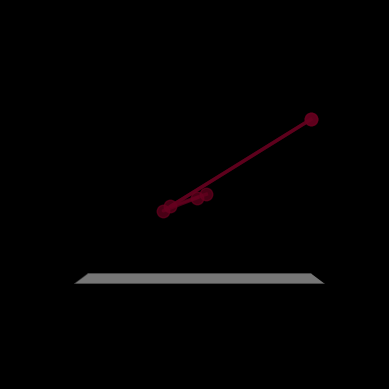

In [7]:
fk_array = np.zeros((n_frames, 3, 3))
fk_array[:, 0, :] = fk["L_shoulder"]
fk_array[:, 1, :] = fk["L_elbow"]
fk_array[:, 2, :] = fk["L_wrist"]

ground_truth = {"L_arm": kin_array}
fk_arm = {"L_arm": fk_array}

animate_3d_points(
    points3d=ground_truth,
    points3d_second=fk_arm,
    export_path="mouse_fk_ik_elev_0_azim_0.mp4",
    frame_no=50,
    elev=0,
    azim=0,
    fps=100,
    marker_types={"L_arm": "o"},
)